In [1]:

#alguns imports

import sys
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
7,application_1653516122854_0008,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:

#criar uma instância SparkSession

#spark = SparkSession\
    #.builder\
    #.appName("Dataset")\
    #.config("spark.sql.shuffle.partitions",6)\
    #.config("spark.sql.repl.eagerEval.enabled", True)\
    #.getOrCreate()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:

#leitura do dataset relativo ao ano 1959
df_raw = spark.read.csv("s3://bigdatanoaa/Dataset/1959.csv", header="false", inferSchema="true", sep=",")  
  
#renomear as colunas
df_raw = df_raw.toDF("ID", "DATE", "ELEMENT", "DATA VALUE", "MFLAG", "QFLAG", "SFLAG", "OBS_TIME") 


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:

#colunas irrelevantes
cols_to_drop = ['MFLAG', 'QFLAG', 'SFLAG', 'OBS_TIME']

#colunas de interesse
cols_interest = [x for x in df_raw.columns if x not in cols_to_drop]

#eliminação das colunas irrelevantes
df_raw_interest = df_raw.select(cols_interest)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:

# Os valores correspondentes às temperaturas e preciciptação apresentam inicialmente um formato de tenth of degrees
# É preciso dividir esses valores por 10 de modo a obter o valor em graus centígrados

df_raw_interest = df_raw_interest.withColumn("DATA VALUE",
    when((col("ELEMENT") == "TMIN")|(col("ELEMENT") == "PRCP"),
    round((col("DATA VALUE")/10),2)).otherwise(col("DATA VALUE")))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:

#Passagem das datas para forma de data de modo a conseguirmos comparar as datas
df_raw_interest = df_raw_interest.withColumn("DATE",to_date(col("DATE").cast(StringType()),"yyyyMMdd"))
                                             
#Filtragem de modo a obter apenas os valores da temperatura mínima, removendo outliers
df_tmin = df_raw_interest.filter((col("ELEMENT") == "TMIN") & (col("DATA VALUE") < 40))

#Renomeação das colunas
df_tmin = df_tmin.toDF("CODIGO","DATA","ELEMENTO","VALOR")

#Filtragem de modo a obter apenas os valores da precipitação, removendo outliers
df_prcp = df_raw_interest.filter((col("ELEMENT") == "PRCP") & (col("DATA VALUE") >= 0))

#União dos dados da temperatura mínima com os dados da precipitação, quando os dias e as estações metereológicas são iguais
join_data = (df_tmin.join(df_prcp).where((col("DATA") == df_prcp["DATE"]) & (col("CODIGO") == df_prcp["ID"]) )
                                         .drop("DATE"))

#Filtragem de modo a obter os dados relativos a Portugal
df_plot = join_data.filter(col("CODIGO").substr(1,2)  == "PO")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

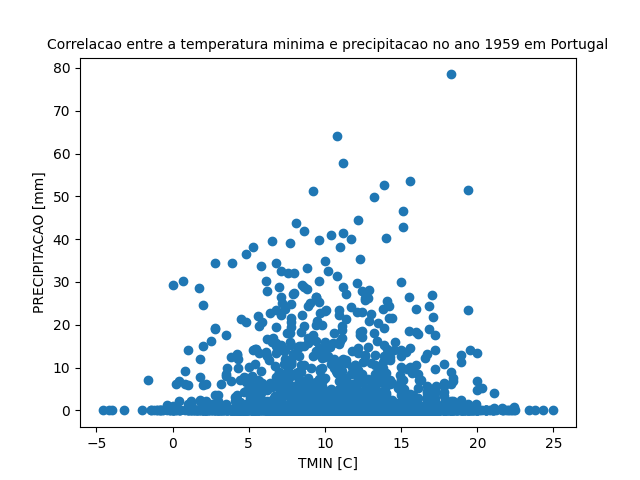

In [7]:

#São feitos os imports novamente de modo a permitir a visualização do gráfico
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Preparação dos dados para  gráfico
df_plot = df_plot.toPandas()

#Construção do gráfico de correlação entre a temperatura mínima e precipitação em Portugal no ano de 1959
plt.scatter(df_plot["VALOR"], df_plot["DATA VALUE"])
plt.xlabel('TMIN [C]')
plt.ylabel('PRECIPITACAO [mm]')
plt.title('Correlacao entre a temperatura minima e precipitacao no ano 1959 em Portugal',fontsize=10)
plt.show()

#Comando local para permitir a visualização do gráfico
%matplot plt
